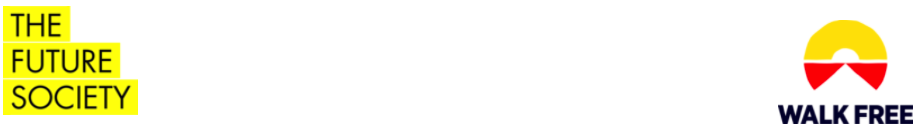

#*Project AIMS (AI against Modern Slavery)*
---




##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1FthUKyhPd5rZrnx61EgzkDRHkS5pOb4j/view?usp=sharing).

# Supply chain disclosure
## Does the company’s statement identify the suppliers in their supply chain and/or the geographic regions where their supply chain operates?
This task aims to build a system to identify whether the company’s statement lists the suppliers in their supply chain and/or the geographic regions where their supply chain operates. These policies must be explicit and go beyond vague statements of intended actions. This metric requires a list of the names of countries and/or suppliers, not simply a statement outlining the total number of countries or suppliers. The mapping can include a list of the names of suppliers or a list of the specific countries or regions where goods are sourced. Some company statements include graphs or pie charts indicating where their company supply chain is based, which made the text extraction for this metric particularly challenging. This is an issue to be addressed in the upcoming chapters.
 
Please refer to[ WikiRate's UK Modern Slavery Act Research on MSA supply chain disclosure metric](https://wikirate.org/Walk_Free_Foundation+MSA_supply_chain_disclosure) or [Home Office Guidance, page 27](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/471996/Transparency_in_Supply_Chains_etc__A_practical_guide__final_.pdf).
 
### Labelled dataset
When building the labelled dataset, if the company specifies at least one region, country, or area that feeds into their supply chain, the label given to the statement is 'Geographical'. If the company discloses a list of suppliers, the label is 'Facility/Supplier'. If the company specifies both a region, country, or area and a list of suppliers, annotators selected the labels 'Geographical' and 'Facility/Supplier'. If any of these labels were given to the statement, the statement was labelled with ‘Yes/1’ for this task. If no such disclosure exists, then the label was ‘No/0’. The annotations also included a Comment that copies relevant information from the statement.
# Approach
 
* First, load the test data. We use this data to evaluate the different LF functions we created.
* Install Snorkel and other necessary requirements.
* Create the LF functions
* Gather detected information
 
 

In [ ]:
#!pip install snorkel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


In [ ]:
import pandas as pd
import numpy as np
import snorkel
from snorkel.labeling import labeling_function
from snorkel.labeling.model import LabelModel
from snorkel.labeling import LabelingFunction
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sys
from utils import evaluation_rb
import re
import nltk
import nltk.data
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

When building the labelled dataset, if the company specifies at least one region, country, or area that feeds into their supply chain, the label given to the statement is 'Geographical'. If the company discloses a list of suppliers, the label is 'Facility/Supplier'. If the company specifies both a region, country, or area and a list of suppliers, then annotators selected the label 'Geographical' and 'Facility/Supplier'. If any of these labels were given to the statement, for this task, the statement was labelled with ‘Yes/1’. If no such disclosure exists, then the label was ‘No/0’. The annotations also included a Comment that copies relevant information from the statement.
The cases marked as "Unknown" are ignored since we are using a simplified metric. Drop non-unique values and cases labelled as "Unknown".


### 🗄️ You can access the data used in this notebook [here](https://drive.google.com/file/d/1gr9PbPTaYLnhVKJ6eraJboPmvLZ_E14J/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).


In [ ]:
df_test = pd.read_csv("labeled-dataset.csv")
text_column = "TEXT"
metric_column = "Walk Free Foundation+MSA supply chain disclosure"

In [ ]:
df_test = df_test[df_test['TEXT'].notna()]
df_test = df_test.drop_duplicates(subset = 'TEXT')
df_test["Text"] = df_test["TEXT"]

print(df_test[metric_column].value_counts())

No                                     799
Geographical                           342
Geographical, Facility/Supplier         61
Unknown                                 58
Facility/Supplier                       57
Geographical, No                         4
Facility/Supplier, No                    3
Geographical, Facility/Supplier, No      2
Name: Walk Free Foundation+MSA supply chain disclosure, dtype: int64


## Labelling functions

The method explored is based on labelling functions that use the Snorkel framework to process, build and manage training datasets without manual labelling. The labelling functions applied were multiple keyword searches by using regular expression matching within the text. This method creates a labelling function with a given name which will tag a statement as a label if it matches the given expression to identify the geographic regions. The list of keywords used to accomplish this goal is  '''map our supply'', ''map supply'', ''map factory', ''map our factory'', ''map our suppliers'', '' identify the suppliers'', ''identify suppliers', ''disclose supply'', ''disclosing supply'', '' we operate in'', '' list of countries'', ''list of regions'', ''supply chain is based'', ''disclose suppliers'', ''disclosing suppliers'', ''source country of origin of our suppliers'', 'source country', ''suppliers based in'', ''source from', 'sourcing','sourcing map', ''diagram below'', ''manufactures in'', ''who are based in', ''import from'', ''sourcing hub', ''supplier sites based'', ''suppliers sites based'', ''businesses sites based'', ''operations are predominantly located'', ''operations are located in'', ''from manufacturers based in'', 'commodities”, “region''.

The output of the system is a prediction about whether a sentence could be classified as a geographical region. The list of keywords is a set of countries, regions, and continents. 

Possibility: Look up names of countries, have a function for each country name and try to correlate.

In [ ]:
ABSTAIN = -1
NO = 0
YES = 1

def keyword_lookup(x, expression, label):
    '''
    simple labeling function, that tags x as the given label if the expression matches the text
    '''
    return label if re.search(expression, str(x[text_column]).lower()) else ABSTAIN

def make_keyword_lf(expression, name='noname', label=YES ):
    '''
    creates a labeling function with a given name. Will tag x as label if it matches the given expression
    '''
    if name=='noname':
        name=f"keyword_{expression[0]}"
    return LabelingFunction(
        name=name,
        f=keyword_lookup,
        resources=dict(expression=expression, label=label),
    )

def sentences_after(expressions,text,n_sentences=10,n_to_print=10):
    '''
    Fetch the n sentences after a given expression. Optionally, print them'''
    printed = 0
    for regex in expressions:
            list_sentences = sent_detector.tokenize(text.strip().lower())
            sentences_with_keyword = [ list_sentences[i:i+n_sentences] for i,sentence in enumerate(list_sentences) if re.search(regex,sentence) and len(sentence)< 1000]
            if(len(sentences_with_keyword) > 0):
                
                return [ str(sentence) for sentence in sentences_with_keyword ]
            if(printed==n_to_print):
                break;
      

## Import country names, continents

In [ ]:
!curl https://gist.githubusercontent.com/radcliff/f09c0f88344a7fcef373/raw/2753c482ad091c54b1822288ad2e4811c021d8ec/wikipedia-iso-country-codes.csv > countries.csv
countries = pd.read_csv("countries.csv")    
country_list = [country.lower() for country in countries["English short name lower case"].values]
continents = continents = ["asia","africa","america","americas","europe","australia","oceania","australasia", "north america","south america"]
region_list = ["south-central asia","balkan","northern africa","polynesia","balkans","southern europe","central africa","caribbean","antarctica","western asia","oceania","australia","western europe","caucasus","caribbean","arabian peninsula","lesser antilles","eastern europe","central america ","west africa","north america","central south america","southern africa","southeast asia","eastern africa, african great lakes","south-east asia","north north america","greater antilles","western south america","eastern asia","south-east asia","north west south america","eastern africa","central america","balkan peninsula","mediterranean","northern europe","africa, middle east","southern south america","melanesia, ","northern south america","caucasus","micronesia","north eastern south america","middle east","central asia","middle east","maritime southeast asia, melanesia","arabian peninsula","north-eastern south america","south america","southeastern europe", "western asia"]
country_list.append("the uk")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9311  100  9311    0     0  29372      0 --:--:-- --:--:-- --:--:-- 29279


In [ ]:
expr = [ region for region in continents+country_list+region_list]
regex = '|'.join(expr)

In [ ]:
country_keywords = country_list
nouns_to_identify = continents

def lf_contains_reg_threshold(x,threshold):
    region_count = len(set(re.findall("("+regex+")",x.TEXT.lower())))
    if region_count == 0:
        return NO
    return YES if region_count > threshold else ABSTAIN

def make_keyword_lf(threshold, label=ABSTAIN):
    return LabelingFunction(
        name=f"count_regions_threshold_{threshold}",
        f=lf_contains_reg_threshold,
        resources=dict(threshold=threshold),
    )

## Define our labelling functions

In [ ]:
regions_3_threshold = make_keyword_lf(3)
functions = [
        regions_3_threshold,
]

In [ ]:
%%time

applier = PandasLFApplier(functions)
L_train = applier.apply(df_test, progress_bar = False)
L_test = applier.apply(df_test, progress_bar = False)


majority_model = MajorityLabelVoter()
preds_train_maj = majority_model.predict(L=L_test)
y_predicted_maj = [v if v == 1 else 0 for v in preds_train_maj]

CPU times: user 27.9 s, sys: 3.51 ms, total: 27.9 s
Wall time: 28 s


## Apply functions, check metrics

In [ ]:
y_test = df_test[metric_column].map({'No':0, 'Geographical':1, 'Unknown':0, 'Geographical, Facility/Supplier':1,
       'Facility/Supplier':0, 'unknown':0, 'Geographical, No':0,
       'Facility/Supplier, No':0, 'Geographical, Facility/Supplier, No':0,np.nan:0})

print(classification_report(y_test.values, y_predicted_maj))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1159
           1       0.43      0.54      0.48       403

    accuracy                           0.69      1562
   macro avg       0.62      0.64      0.63      1562
weighted avg       0.72      0.69      0.70      1562



After collecting statistics about LFAnalysis, MajorityLabelVoter is used to perform the classification task to predict the label. The predicted variables are evaluated against their respective ground-truth value. Finally, the label outputs are evaluated. The method yields 84% accuracy. 

The main challenges ahead are related to include keywords about specific company names, industries, and economic sectors. There is external information about this that could be exploited to lift the text classification performance. Another challenge arises in interpreting the results because the accuracy of the initial ground truth data used in this exercise needs to be explored and evaluated in more detail to make conclusions and take steps to improve the data quality.




#Results

Evaluation of the rule-based model


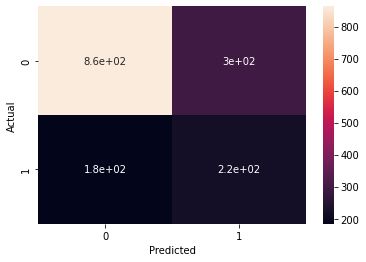

Confusion Matrix:
 [[863 296]
 [184 219]]
Accuracy Score: 0.6927016645326505
Precision Score: 0.7213123636364112
Recall Score: 0.6927016645326505
F1 Score: 0.7036466681278113


In [ ]:
evaluation_rb.main(y_test.values,y_predicted_maj)

In [ ]:
LFAnalysis(L=L_train, lfs=functions).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
count_regions_threshold_3,0,"[0, 1]",0.493598,0.0,0.0


# Generate output

Determine the tense. In case were positively marked a text as having identified or not a modern slavery incident

In [ ]:
def determine_tense_input(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)
    
    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"] and word[0] not in ["have","has"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]])
    
    if max(tense, key=tense.get) == 0:
        return 'present'
    else:
        return max(tense, key=tense.get)

In [ ]:
import random

def extract_expression_in_sentences(text,expression):
    if pd.notnull(text) and re.search(expression,text.lower()):
        list_sentences = sent_detector.tokenize(text.strip().lower())
        sentences_with_keyword = [ {"element_sentence_text":sentence,"element_span":match.span(),"element_text":expression.pattern,"element_sentence_tense":determine_tense_input(sentence)} for sentence in list_sentences for match in [re.search(expression,sentence)] if match != None]
        if(len(sentences_with_keyword) > 0):
            return sentences_with_keyword

## Define information extraction functions

For each of the labelling functions, we define how to fetch the relevant part of the text to store in the dataframe

In [ ]:
def get_relevant_chunk_regex(x,regex):
    return extract_expression_in_sentences(x,regex)

def get_relevant_chunk_region(x):
    return [matches[0] 
     for expre in expr 
     for matches in [ get_relevant_chunk_regex(x,re.compile(expre )) ]
     if matches != None
      ]

#0: negated terms
#1: check_keywords_after_case_study
#2: check_negative_keywords_after_case_study
#3: general_terms_light,
#4: general_terms,regions_3_threshold
element_extraction_map = {
    0: get_relevant_chunk_region,
}
def get_relevant_chunk_according_to_label(x,label_index):
    matches = element_extraction_map[label_index](x)
    if matches!= None and len(matches) > 0:
        return matches

In [ ]:
#predicted_labels = majority_model.predict(L=L_train)
predicted_labels = y_predicted_maj

In [ ]:
%%time
df_copy = df_test.reset_index()
#.drop("index",axis=1).drop("Unnamed: 0",axis=1)

df_copy["Incidents identified predicted label"] = predicted_labels

for i, f in enumerate(functions):
    print(i,f.name)
    df_copy["Incidents identified data " + f.name] = df_copy[text_column].apply(lambda x: get_relevant_chunk_according_to_label(x,i))

0 count_regions_threshold_3
CPU times: user 1min 23s, sys: 597 ms, total: 1min 23s
Wall time: 1min 23s


In [ ]:
df_copy[['Incidents identified predicted label',	'Incidents identified data count_regions_threshold_3']]

,Incidents identified predicted label,Incidents identified data count_regions_threshold_3
0,1,[{'element_sentence_text': '2. about our busin...
1,0,[{'element_sentence_text': 'statement under th...
2,1,[{'element_sentence_text': 'for the full cauti...
3,1,[{'element_sentence_text': 'this has included ...
4,0,[{'element_sentence_text': 'intelcorporation a...
...,...,...
1557,0,[{'element_sentence_text': 'modern slavery and...
1558,0,[{'element_sentence_text': 'group structure th...
1559,0,[{'element_sentence_text': 'in addition to its...
1560,0,None
